In [3]:
# import requirements
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import save_model

print('TensorFlow version: ', tf.__version__)

TensorFlow version:  2.18.0


# Transfer Learning

## Downloading Data

In [4]:
# download dataset
path = '/content/garbage_classification_train_test.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

## Train, Test and Validation Sets

In [5]:
# select train & test datasets
train_dir = 'garbage_classification_train_test/train_set'
test_dir = 'garbage_classification_train_test/test_set'

In [6]:
# set sizes
img_size = (224,224)
batch_size = 32

In [7]:
# TRAIN DATA : data augmentation done to prevent overfitting
training_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 10,
    horizontal_flip = True,
    zoom_range = 0.1,
    validation_split = 0.2)

In [8]:
# prepare train dataset
train_dataset = training_generator.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

Found 1617 images belonging to 6 classes.


In [9]:
# check classes
print(train_dataset.classes)
print(train_dataset.class_indices)

[0 0 0 ... 5 5 5]
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


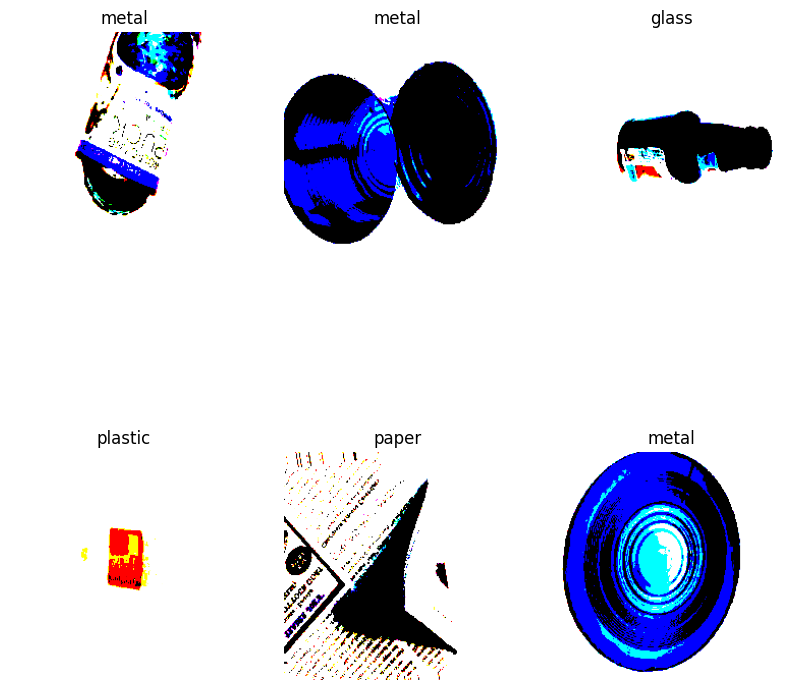

In [10]:
# show first 6 images of a batch
class_names = list(train_dataset.class_indices.keys())
images, labels = next(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index])
    plt.axis("off")
plt.show()

In [11]:
# VALIDATION DATA : prepare validation dataset from train dataset
validation_dataset = training_generator.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 402 images belonging to 6 classes.


In [12]:
# TEST DATA : no data augmentation done, only rescaling
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
# prepare test dataset
test_dataset = test_generator.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

Found 508 images belonging to 6 classes.


## Loading Pre-trained ResNet50

In [14]:
# select pre-trained model MobileNetV2 trained on the dataset ImageNet
base_model = tf.keras.applications.ResNet50(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet')

In [15]:
# show summary of base model
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
# show number of layers
len(base_model.layers)

175

## Freezing Layers

In [17]:
# keep the pre-trained weights of base model fixed
for layer in base_model.layers:
  layer.trainable = False

for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

In [18]:
# show expected output of base model
base_model.output

<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_174>

## Custom Dense Layer

In [19]:
# NEW DENSE LAYERS : add custom head on top of the base model to build new model
# NOTE : number of dense layers added & neurons used were recommendations by ChatGPT
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)                 # reduce spatial dimensions of output from base model to a single value
head_model = Dense(units = 512, activation='relu')(head_model)    # add dense layer 1
head_model = Dropout(rate = 0.3)(head_model)
head_model = Dense(units = 256, activation='relu')(head_model)    # add dense layer 2
head_model = Dropout(rate = 0.3)(head_model)
head_model = Dense(6, activation='softmax')(head_model)

## Building and Training Neural Network

In [20]:
# show expected input of base model
base_model.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>

In [21]:
# build new model
new_model = Model(inputs = base_model.input, outputs = head_model)

In [22]:
# show summary of new model
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,769,670 (94.49 MB)

 Trainable params: 1,181,958 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
# show number of layers
len(new_model.layers)

181

In [24]:
# compile new model
new_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
# set up early stop for training new model
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [26]:
# train new model
history = new_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 15,
    callbacks = [early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 750ms/step - accuracy: 0.5458 - loss: 1.2493 - val_accuracy: 0.7488 - val_loss: 0.6476
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 494ms/step - accuracy: 0.8520 - loss: 0.4415 - val_accuracy: 0.6841 - val_loss: 0.8434
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 505ms/step - accuracy: 0.8598 - loss: 0.3620 - val_accuracy: 0.7886 - val_loss: 0.5887
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 482ms/step - accuracy: 0.9187 - loss: 0.2522 - val_accuracy: 0.7388 - val_loss: 0.8260
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 495ms/step - accuracy: 0.9322 - loss: 0.1936 - val_accuracy: 0.7711 - val_loss: 0.6902
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 474ms/step - accuracy: 0.9286 - loss: 0.1870 - val_accuracy: 0.7960 - val_loss: 0.6031
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.9443 - loss: 0.1592 - val_accuracy: 0.8010 - val_loss: 0.6579
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 475ms/step - accuracy: 0.9482 - loss: 0.1458 - val_accu

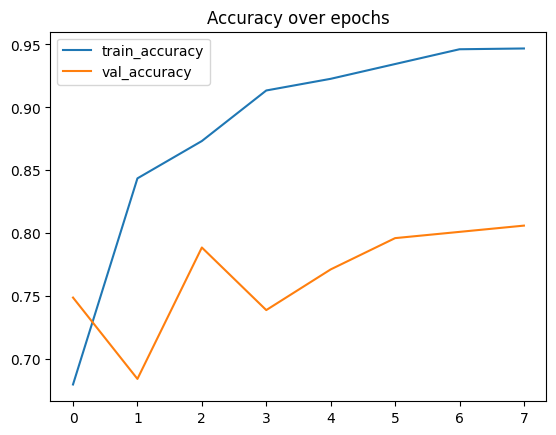

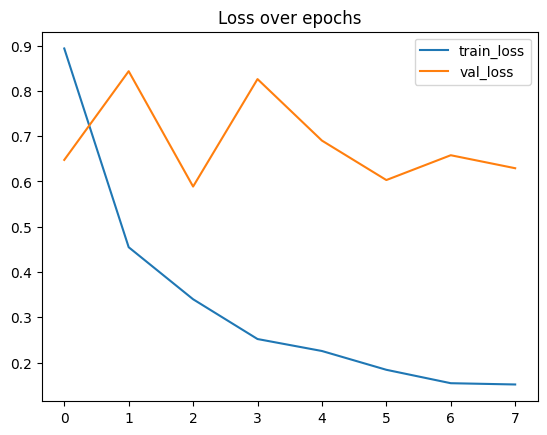

In [27]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

## Predictions

In [28]:
# check classes
print(test_dataset.classes)
print(test_dataset.class_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5
 5 5 5 5 5 5 5 5 5 5 5 5 

In [29]:
# predict class probabilities on test dataset using new model
predictions = new_model.predict(test_dataset)
predictions = np.argmax(predictions, axis = 1)
predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 538ms/step


array([0, 0, 0, 2, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 3,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 4, 1, 1, 1, 1, 2, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 5, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,

In [30]:
# show classes on test dataset
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

## Model Evaluation

In [31]:
# check accuracy
accuracy_score(test_dataset.classes, predictions)

0.8641732283464567

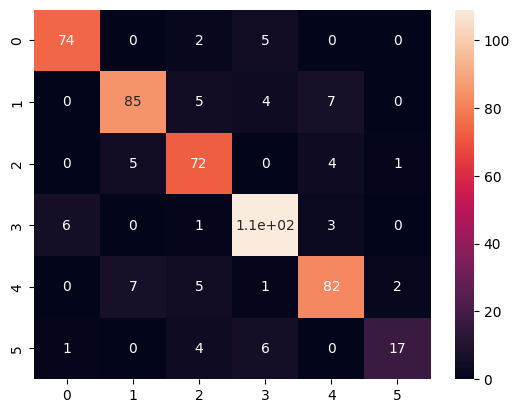

In [32]:
# display confusion matrix
conf_matrix = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(conf_matrix, annot = True);

In [33]:
# display classification report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        81
           1       0.88      0.84      0.86       101
           2       0.81      0.88      0.84        82
           3       0.87      0.92      0.89       119
           4       0.85      0.85      0.85        97
           5       0.85      0.61      0.71        28

    accuracy                           0.86       508
   macro avg       0.86      0.83      0.84       508
weighted avg       0.86      0.86      0.86       508



# Fine-Tuning

In [34]:
# prepare base model for fine tuning
base_model.trainable = True
for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

In [35]:
# compare number of layers for base and new models
print(len(base_model.layers))
print(len(new_model.layers))

175
181


In [36]:
# fine tune portion of base model layers (last 30 layers)
fine_tuning_at = 124
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [37]:
# compile fine-tuned model
new_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [38]:
# train fine-tuned model
history = new_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 15,
    callbacks = [early_stop]
)

Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 661ms/step - accuracy: 0.8858 - loss: 0.3479 - val_accuracy: 0.7711 - val_loss: 0.6291
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 475ms/step - accuracy: 0.9156 - loss: 0.2406 - val_accuracy: 0.7910 - val_loss: 0.6460
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 467ms/step - accuracy: 0.9319 - loss: 0.1926 - val_accuracy: 0.7886 - val_loss: 0.6878
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.9332 - loss: 0.1709 - val_accuracy: 0.7886 - val_loss: 0.6339
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 480ms/step - accuracy: 0.9517 - loss: 0.1627 - val_accuracy: 0.8060 - val_loss: 0.5905
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 475ms/step - accuracy: 0.9599 - loss: 0.1280 - val_accuracy: 0.7960 - val_loss: 0.6735
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 477ms/step - accuracy: 0.9668 - loss: 0.1033 - val_accuracy: 0.8134 - val_loss: 0.6125
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 511ms/step - accuracy: 0.9609 - loss: 0.1274 - val_accu

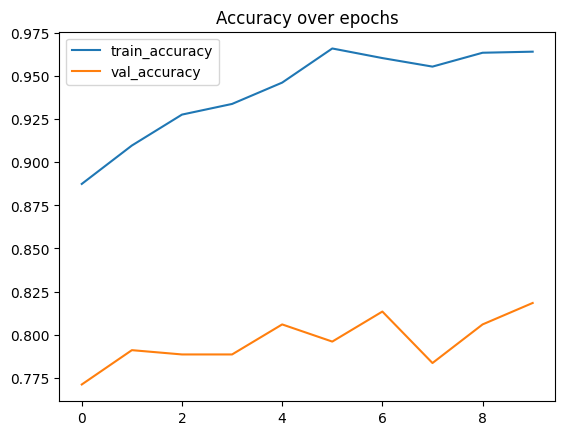

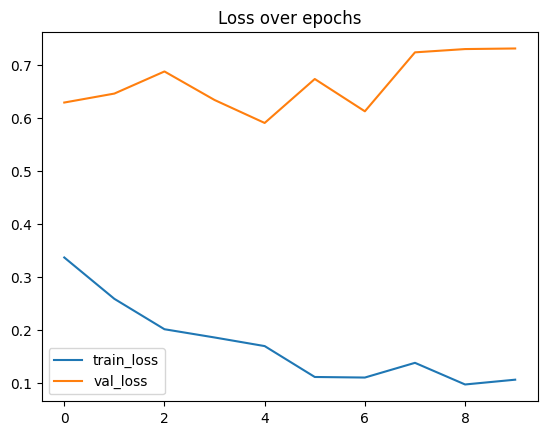

In [39]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [40]:
# predict class probabilities on test dataset using fine-tuned model
predictions = new_model.predict(test_dataset)
predictions = np.argmax(predictions, axis = 1)
predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step


array([0, 0, 0, 2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 5, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 0, 3, 3, 5, 3, 3, 3, 3, 3,

In [41]:
# check accuracy
accuracy_score(test_dataset.classes, predictions)

0.8877952755905512

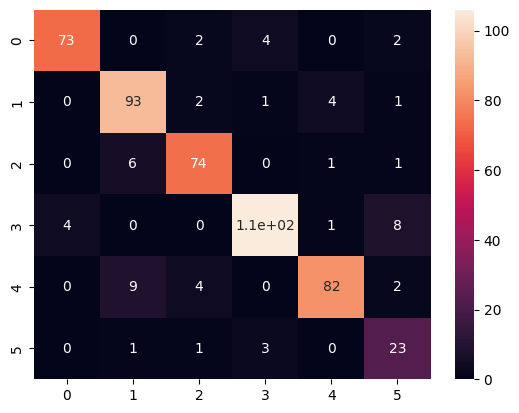

In [42]:
# display new confusion matrix
conf_matrix = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(conf_matrix, annot = True);

In [43]:
# display new classification report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        81
           1       0.85      0.92      0.89       101
           2       0.89      0.90      0.90        82
           3       0.93      0.89      0.91       119
           4       0.93      0.85      0.89        97
           5       0.62      0.82      0.71        28

    accuracy                           0.89       508
   macro avg       0.86      0.88      0.87       508
weighted avg       0.89      0.89      0.89       508



In [44]:
# save fine-tuned model
model_json = new_model.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

saved_model = save_model(new_model, '/content/weights.hdf5')